In [10]:
import pickle as pkl
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import sys
home = '/home/nina/CopulaGP/'
sys.path.insert(0, home)
import bvcopula
from vine import CVine


i=1
with open(f'/home/nina/CopulaGP/out/ST260_Day1_trained.pkl',"rb") as f:
    trained_all = pkl.load(f)

with open(f'/home/nina/CopulaGP/out/ST260_Day1_G_trained.pkl',"rb") as f:
    trained_gauss = pkl.load(f)

device = 'cuda:0'

In [28]:
M = 109
trained = trained_all
# print(len(trained['models']))
models = [[trained['models'][i][j] for j in range(M-1-i)] for i in range(min(104,M-1))]

sem_tol = 0.1
%time vine = CVine.marginalize(models,torch.tensor(trained['X'],device=device).float())
%time MI = vine.inputMI(sem_tol=sem_tol, s_mc_size=50, r_mc_size=20, sR_mc_size=1000, v=True)
MI

CPU times: user 11min 50s, sys: 1.17 s, total: 11min 52s
Wall time: 13min 2s
Start calculating p(r) 0


RuntimeError: CUDA out of memory. Tried to allocate 360.00 MiB (GPU 0; 10.76 GiB total capacity; 6.74 GiB already allocated; 18.12 MiB free; 6.84 GiB reserved in total by PyTorch)

(tensor([0.0905], device='cuda:0'),
 tensor(0.1079, device='cuda:0'),
 tensor([1.1156], device='cuda:0'),
 tensor(0.0776, device='cuda:0'))

In [2]:
# calculate H(y,v|x)

N_points = 200
inputs = torch.linspace(0,1,N_points,device=device).float()

trained= trained_gauss

Hs = []

for reps in tqdm(range(10)):
    %time vine = CVine.marginalize(trained['models'],inputs)
    sem_tol = 0.1
    %time H20 = vine.entropy(sem_tol=sem_tol,mc_size=1500,v=True).cpu().numpy()

    Hs.append([H20])

CPU times: user 33.6 s, sys: 47.1 ms, total: 33.7 s
Wall time: 33.7 s
tensor(2.1292, device='cuda:0')
tensor(1.5077, device='cuda:0')
tensor(1.2316, device='cuda:0')
tensor(1.0665, device='cuda:0')
CPU times: user 5min 19s, sys: 243 ms, total: 5min 19s
Wall time: 5min 19s
CPU times: user 34 s, sys: 104 ms, total: 34.1 s
Wall time: 34.1 s
tensor(2.0969, device='cuda:0')
tensor(1.4812, device='cuda:0')
tensor(1.2144, device='cuda:0')
tensor(1.0513, device='cuda:0')
CPU times: user 5min 13s, sys: 255 ms, total: 5min 14s
Wall time: 5min 14s
CPU times: user 33.9 s, sys: 71.9 ms, total: 33.9 s
Wall time: 33.9 s
tensor(2.0854, device='cuda:0')
tensor(1.4811, device='cuda:0')
tensor(1.2077, device='cuda:0')
tensor(1.0463, device='cuda:0')
CPU times: user 5min 6s, sys: 188 ms, total: 5min 6s
Wall time: 5min 6s
CPU times: user 33.9 s, sys: 120 ms, total: 34.1 s
Wall time: 34 s
tensor(2.0713, device='cuda:0')
tensor(1.4670, device='cuda:0')
tensor(1.1959, device='cuda:0')
tensor(1.0364, device='c

In [3]:
with open(f"{home}/results/HYgX_subpop_Csmall_onlygauss.pkl","wb") as f:
    pkl.dump([20,inputs.cpu().numpy(),Hs],f)

In [3]:
# calculate H(y,v|x)

N_points = 100
inputs = torch.linspace(0,1,N_points,device=device).float()

vines, Hs = [],[]

for trained in [trained_all,trained_gauss]: #day-1

    %time vine = CVine.marginalize(trained['models'],inputs)

    sem_tol = 0.1
    %time H1 = vine.truncate(1).entropy(sem_tol=sem_tol,mc_size=10000,v=True).cpu().numpy()
    %time H20 = vine.entropy(sem_tol=sem_tol,mc_size=4000,v=True).cpu().numpy()
  
    print(H20.mean())
    
    vines.append(vine)
    Hs.append([H1,H20])

CPU times: user 11.8 s, sys: 32.7 ms, total: 11.9 s
Wall time: 11.9 s
CPU times: user 11.1 s, sys: 8.9 ms, total: 11.1 s
Wall time: 11.1 s
tensor(1.3094, device='cuda:0')
CPU times: user 1min 35s, sys: 35.3 ms, total: 1min 35s
Wall time: 1min 35s
-16.062029
CPU times: user 10.9 s, sys: 39.9 ms, total: 11 s
Wall time: 11 s
CPU times: user 7.1 s, sys: 3.77 ms, total: 7.1 s
Wall time: 7.09 s
tensor(1.2708, device='cuda:0')
CPU times: user 1min 13s, sys: 27.7 ms, total: 1min 13s
Wall time: 1min 13s
-16.225332


In [4]:
help(vines[0])

Help on CVine in module vine.vine object:

class CVine(builtins.object)
 |  This class represents copula C-Vine
 |  
 |  Methods defined here:
 |  
 |  __init__(self, layers, inputs, device=device(type='cpu'))
 |      Attributes
 |      ----------
 |      N: int
 |          Number of variables
 |      inputs: int
 |          Input points
 |      layers:
 |          A list of layers. Each layer should contain N-1-i
 |          MixtureCopula models, where i is the layer's number.
 |  
 |  create_subvine(self, input_idxs:torch.Tensor)
 |      Creates a CVine object, defined on the subset of inputs
 |      input_idxs: torch.Tensor
 |          indexes of the input elements to keep
 |  
 |  entropy(self, alpha=0.05, sem_tol=0.001, mc_size=10000, v=False)
 |      Estimates the entropy of the mixture of copulas 
 |      with the Robbins-Monro algorithm.
 |      Parameters
 |      ----------
 |      alpha : float, optional
 |          Significance level of the entropy estimate.  (Default: 0.05)

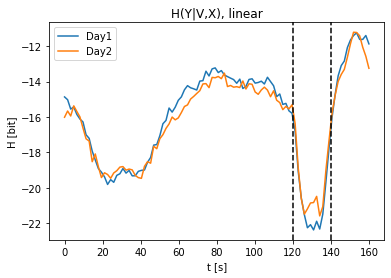

In [6]:
def one_plot(H,c,l,style='solid'):
    plt.plot(inputs.cpu().numpy()*160,H,c=c,label=f"Day{l}",linestyle=style)
for i in range(2):
    one_plot(Hs[i][1],f"C{i}",i+1)
plt.axvline(120,color='k',linestyle='dashed')
plt.axvline(140,color='k',linestyle='dashed')
plt.xlabel('t [s]')
plt.ylabel('H [bit]')
plt.title(f'H(Y|V,X), linear')
plt.legend()

In [7]:
1-Hs[0][1].mean()/Hs[1][1].mean()

0.01006472110748291

In [9]:
# calculate I(u^x,x)
MIs = []

for trained in [trained_gauss]: #day-1

    sem_tol = 0.1
    %time vine = CVine.marginalize(trained['models'],torch.tensor(trained['X'],device=device).float())
    %time MI = vine.truncate(19).inputMI(sem_tol=sem_tol, s_mc_size=50, r_mc_size=20, sR_mc_size=1000, v=True)
    
    MIs.append(MI)

CPU times: user 37.5 s, sys: 104 ms, total: 37.6 s
Wall time: 37.5 s
Start calculating p(r) 0
Finished in 5 steps
15.0,12.8,2.14,                        5.62,5.15
Start calculating p(r) 1
Finished in 5 steps
15.5,13.5,2.04,                        4.16,3.81
Start calculating p(r) 2
Finished in 9 steps
15.5,13.3,2.16,                        3.38,3.06
Start calculating p(r) 3
Finished in 6 steps
15.6,13.4,2.15,                        2.91,2.64
Start calculating p(r) 4
Finished in 3 steps
15.7,13.5,2.12,                        2.61,2.36
Start calculating p(r) 5
Finished in 2 steps
15.7,13.6,2.11,                        2.38,2.16
Start calculating p(r) 6
Finished in 4 steps
15.7,13.6,2.1,                        2.19,1.99
Start calculating p(r) 7
Finished in 5 steps
15.6,13.5,2.08,                        2.04,1.86
Start calculating p(r) 8
Finished in 4 steps
15.6,13.6,2.08,                        1.94,1.76
Start calculating p(r) 9
Finished in 3 steps
15.8,13.7,2.08,                        1.

In [10]:
#2.18
MI

(tensor([2.0377], device='cuda:0'),
 tensor(0.1355, device='cuda:0'),
 tensor([15.8886], device='cuda:0'),
 tensor(0.0915, device='cuda:0'))

In [12]:
1-2.04/2.17

0.05990783410138245